In [1]:
from scipy import stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


In [2]:
IBGEFILE_UNITS = pd.read_csv("data\IBGEFILE.UNITS.csv")

In [3]:
BGEIDSC_EF2EFFP = pd.read_csv("data\BGEIDSC.EF2EFFP.csv")

In [4]:
BGETCHDATA_PTCHTRANH = pd.read_csv("data\BGETCHDATA.PTCHTRANH.csv")

In [5]:
Extranet2_ExactFuelEvents = pd.read_csv("data\Extranet2.ExactFuelEvents.csv")

In [6]:
Extranet2_ExactFuelTankLevels = pd.read_csv("data\Extranet2.ExactFuelTankLevels.csv")

In [7]:
df_vehicle = IBGEFILE_UNITS

In [8]:
df_levels = Extranet2_ExactFuelTankLevels[['TankId', 'TankLevelPercent', 'TankLevelGallons', 'ExactFuelEventId']]

In [9]:
df_events = Extranet2_ExactFuelEvents[['Id', 'EventTimeStamp', 'EquipmentID','DriverID', 'Latitude', 'Longitude','Speed',
                          'Heading', 'Odometer', 'IgnitionStatus','EFReportReason']]

In [10]:
df_optimization = BGEIDSC_EF2EFFP[['TRUCK', 'TANKCAP']]

In [11]:
df_transaction = BGETCHDATA_PTCHTRANH[['TRNID', 'TRNDAT', 'TRNTIM', 'TRNTS#','TRNDRI', 'TRNUNT', 'TRNPI1', 'TRNPQ1']]

In [12]:
df_transaction = df_transaction[~df_transaction['TRNPI1'].isin(['SCLE', 'CADV', 'DEFD', 'ADD ', 'OIL ', 'UREA', 'DEFC'])] 

## Cast keys to common data type 

In [13]:
df_transaction['TRNUNT'] = df_transaction['TRNUNT'].astype(str);
df_optimization['TRUCK'] = df_optimization['TRUCK'].astype(str);
df_events['Id'] = df_events['Id'].astype(str);
df_levels['ExactFuelEventId'] = df_levels['ExactFuelEventId'].astype(str);
df_events['EquipmentID'] = df_events['EquipmentID'].astype(str);

## Clean column values


In [14]:
df_transaction['TRNUNT'] = df_transaction['TRNUNT'].apply(lambda x: x.strip()).replace('', np.nan);
df_optimization['TRUCK'] = df_optimization['TRUCK'].apply(lambda x: x.strip()).replace('', np.nan);
df_events['Id'] = df_events['Id'].apply(lambda x: x.strip()).replace('', np.nan);
df_levels['ExactFuelEventId'] = df_levels['ExactFuelEventId'].apply(lambda x: x.strip()).replace('', np.nan);
df_events['EquipmentID'] = df_events['EquipmentID'].apply(lambda x: x.strip()).replace('', np.nan);

## Merge Dfs together

In [72]:
#A = pd.merge(df_transaction, df_vehicle, how='inner', left_on='TRNUNT', right_on = 'UNUNIT')
#A.head(5)

In [73]:
#B = pd.merge(A, df_optimization, how = 'inner', left_on = 'UNUNIT', right_on = 'TRUCK')
#B.head(5)

In [74]:
#C = pd.merge(df_events_30, df_event_level, how='inner', left_on='Id', right_on = 'ExactFuelEventId')
#C.head(5)

In [72]:
df_event_level = pd.merge(df_events, df_levels, how='inner', left_on='Id', right_on = 'ExactFuelEventId')

In [77]:
##Remove drivers not likely to be thieves 
df_event_level =  df_event_level[~df_event_level['DriverID'].isin(['SMID', 'BEVL', 'RICS', 'NEWR ', 'MARC ', 'LOVH', 'nan', '36728'])] 

#Clean DriverID column to prepare for Harmonic Mean calculation 
df_event_level['DriverID'] = df_event_level['DriverID'].astype(str); 
df_event_level['DriverID'] = df_event_level['DriverID'].apply(lambda x: x.strip()).replace('', np.nan);

## Calculate Harmonic Mean Per DriverID (Max, Median, Min Frequencies) 

In [84]:
from collections import Counter 
drivers = Counter(df_event_level['DriverID'])
drivers = pd.DataFrame(list(drivers.items()), columns=['DriverID', 'Frequency'])
drivers = drivers.sort_values(by='Frequency', ascending=False)
#drivers.dtypes
drivers_is_1 = drivers.query("Frequency == 1")
drivers_df = drivers[~drivers.index.isin(drivers_is_1.index)]

In [85]:
df_event_level = df_event_level[df_event_level['DriverID'].isin(drivers_df['DriverID'])] 
df_event_level = df_event_level.query("DriverID != ''")

In [96]:
#find count to determine 50th percentile index
drivers.count()

DriverID     911
Frequency    911
dtype: int64

In [123]:
drivers_max = pd.DataFrame(drivers['DriverID'].head(1))
#drivers_max

In [111]:
drivers_median = pd.DataFrame(drivers.loc[455].head(1))
drivers_median.rename(columns={455 : 'DriverID'},inplace=True)
#drivers_median

In [112]:
drivers_min = pd.DataFrame(drivers['DriverID'].tail(1))
#drivers_min

In [163]:
df_event_level_min = df_event_level[df_event_level['DriverID'].isin(drivers_min['DriverID'])] 
df_event_level_min['Id'] = df_event_level_min['Id'].astype(int)

harmonic_mean_min = stats.hmean(df_event_level_min["TankLevelPercent"]) 
#harmonic_mean_min
print(df_event_level_min['Id'].min())
print(df_event_level_min['Id'].max())

16061046
16061059


In [162]:
df_event_level_median = df_event_level[df_event_level['DriverID'].isin(drivers_median['DriverID'])] 
df_event_level_median['Id'] = df_event_level_median['Id'].astype(int)
#df_event_level_median
harmonic_mean_median = stats.hmean(df_event_level_median["TankLevelPercent"]) 
#harmonic_mean_median
print(df_event_level_median['Id'].min())
print(df_event_level_median['Id'].max())

12815980
21055426


In [164]:
df_event_level_max = df_event_level[df_event_level['DriverID'].isin(drivers_max['DriverID'])] 
df_event_level_max['Id'] = df_event_level_max['Id'].astype(int)
#df_event_level_max
harmonic_mean_max = stats.hmean(df_event_level_max["TankLevelPercent"]) 
#harmonic_mean_max
print(df_event_level_max['Id'].min())
print(df_event_level_max['Id'].max())

12649149
21142685


## Plot Sampled DriverIDs and compare their FuelLevelPct trends with respective Harmonic Means

In [204]:
'''The harmonic mean is a measure appropriately used when trying to find the average of rates. 
(In this case, TankLevelPercent over time) See the citation below for ore details and a mathematical defintion ''';

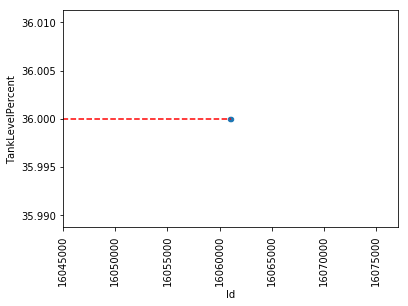

In [186]:
df_event_level_min.plot.scatter('Id','TankLevelPercent')
plt.plot([0, 16061059],[harmonic_mean_min,harmonic_mean_min], 'r--')
plt.xlim(16061059, 16061059)
plt.xticks(rotation=90)
plt.ticklabel_format(useOffset=False, style='plain')
plt.show()

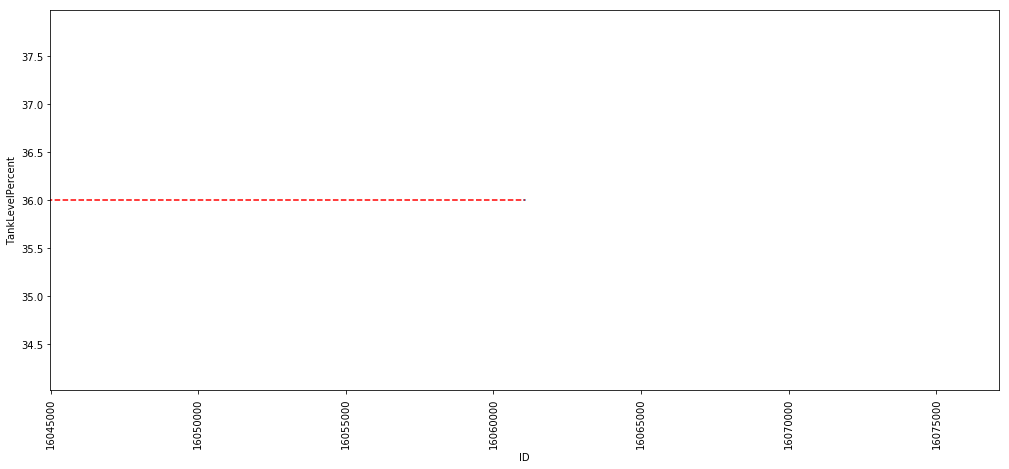

In [187]:
plt.figure(figsize=[17,7])
_ = plt.plot(df_event_level_min.Id, df_event_level_min.TankLevelPercent)
_ = plt.plot([0, 16061059],[harmonic_mean_min,harmonic_mean_min], 'r--')
_ = plt.xlabel('ID')
_ = plt.ylabel('TankLevelPercent')
_ = plt.xlim(16061059, 16061059)
_ = plt.xticks(rotation=90)
_ = plt.ticklabel_format(useOffset=False, style='plain') 
plt.show();

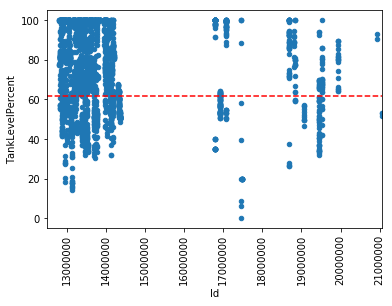

In [188]:
df_event_level_median.plot.scatter('Id','TankLevelPercent')
plt.plot([0, 21055426],[harmonic_mean_median,harmonic_mean_median], 'r--')
plt.xlim(12500000, 21055426)
plt.xticks(rotation=90)
plt.ticklabel_format(useOffset=False, style='plain') 
plt.show()

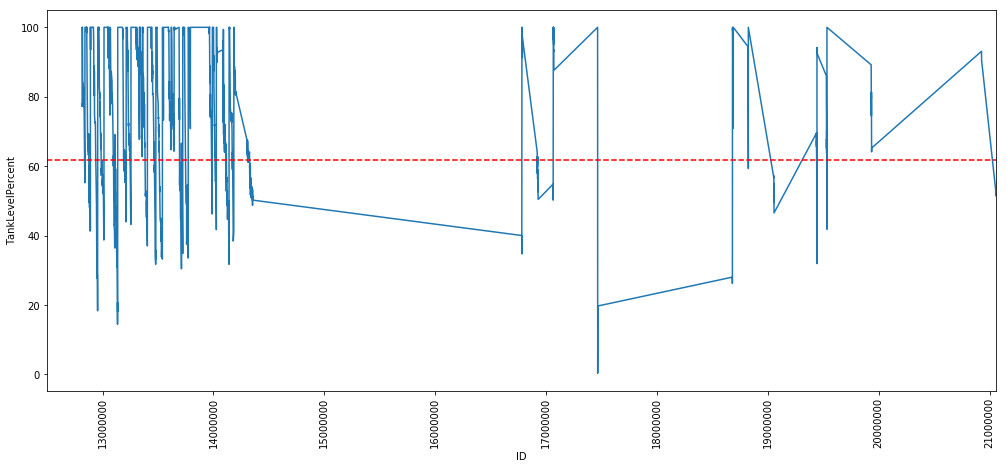

In [189]:
plt.figure(figsize=[17,7])
_ = plt.plot(df_event_level_median.Id, df_event_level_median.TankLevelPercent)
_ = plt.plot([0, 21055426],[harmonic_mean_median,harmonic_mean_median], 'r--')
_ = plt.xlabel('ID')
_ = plt.ylabel('TankLevelPercent')
_ = plt.xlim(12500000, 21055426)
_ = plt.xticks(rotation=90)
_ = plt.ticklabel_format(useOffset=False, style='plain') 
plt.show();

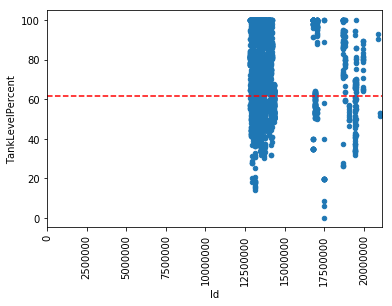

In [190]:
df_event_level_median.plot.scatter('Id','TankLevelPercent')
plt.plot([0, 21142685],[harmonic_mean_median,harmonic_mean_median], 'r--')
plt.xlim(0, 21142685)
plt.xticks(rotation=90)
plt.ticklabel_format(useOffset=False, style='plain') 
plt.show()

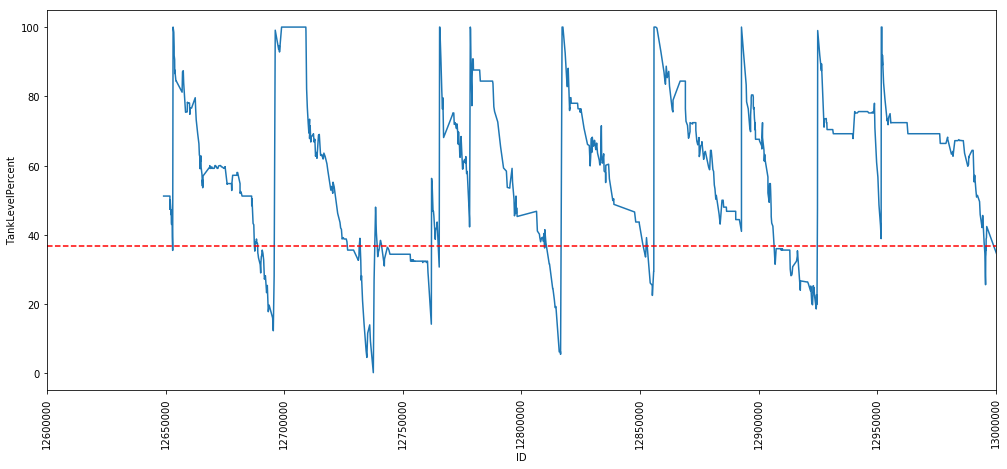

In [191]:
plt.figure(figsize=[17,7])
_ = plt.plot(df_event_level_max.Id, df_event_level_max.TankLevelPercent)
_ = plt.plot([12600000, 13000000],[harmonic_mean_max,harmonic_mean_max], 'r--')
_ = plt.xlabel('ID')
_ = plt.ylabel('TankLevelPercent')
_ = plt.xlim(12600000, 13000000)
_ = plt.xticks(rotation=90)
_ = plt.ticklabel_format(useOffset=False, style='plain') 

plt.show();

## Find records where Drivers Fuel Tank Level Pct is less than repective Harmonic Mean

In [181]:
print(round(harmonic_mean_min, 1))
print(round(harmonic_mean_median, 1))
print(round(harmonic_mean_max, 1))

36.0
61.6
36.8


In [193]:
df_event_level_median_less = df_event_level_median.query("TankLevelPercent < 61.6")

In [196]:
df_event_level_max_less = df_event_level_max.query("TankLevelPercent < 36.8")

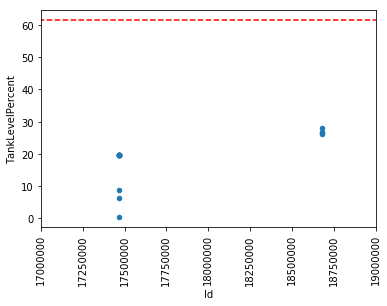

In [199]:
df_event_level_median_less.plot.scatter('Id','TankLevelPercent')
plt.plot([0, 21055426],[harmonic_mean_median,harmonic_mean_median], 'r--')
plt.xlim(17000000, 19000000)
plt.xticks(rotation=90)
plt.ticklabel_format(useOffset=False, style='plain') 
plt.show()

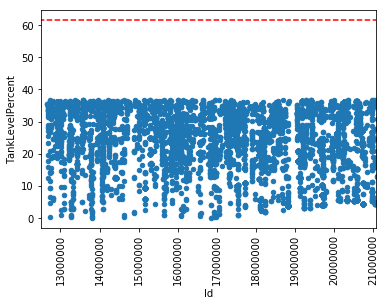

In [197]:
df_event_level_max_less.plot.scatter('Id','TankLevelPercent')
plt.plot([0, 21055426],[harmonic_mean_median,harmonic_mean_median], 'r--')
plt.xlim(12500000, 21055426)
plt.xticks(rotation=90)
plt.ticklabel_format(useOffset=False, style='plain') 
plt.show()

In [202]:
'''For the sampled drivers, TankLevelPercentage values below the harmonic mean may indicate suspicious activity.  
TankLevelPercent values that subsequently go from near zero to higher levels still below the repspecive harmonic mean may be 
indicative of suspicious behavior. More research needs to be done to investigate how the harmonic mean can serve as a indicator 
for outliers that suggest suspicious behavior''';

#### Sources:
#### $^{1}$http://www.statisticalanalysisconsulting.com/measures-of-central-tendency-the-harmonic-mean/